In [1]:
import os
import glob
import sys
import json
import time
import copy
import torch
import click
import pickle
import numpy as np
import logging as log
import cv2
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A

from tqdm import tqdm
from pathlib import Path
from skimage.io import imread
from torch.autograd import Variable
from losses_pytorch.segmentation.twodim.entropy_based_losses import cross_entropy_with_logits_loss

from precode.models import UnetSm
from precode.scoring import jaccard_score
from precode.labels.wheat_segmentation import WHEAT_LABELS
from precode.net_utils import init_determenistic, batch_ids_generator



config = {
    'VERBOSER': True,
    'DEBUG': False,
    'BATCH_SIZE':8,
    'BACKBONE':'?',
    'EPOCHS': 135,
    'LEARNING_RATE': 1e-3, #1e-3
    'STOP_EPOCHS': 205,
    'DATAPATH': '/home/jupyter-fly_cv/Igor/Plants_2/Segment/',
    'DEVICE': torch.device('cuda'),
    'PREFIX': time.strftime("%H-%M:%d-%m-%y_", time.gmtime()),
    'MODELNAME': 'model_plant_segmentation.bin'
}

debugging_info = { 'epoch_score_trace': list(),
                   'epoch_loss_trace': list(),
                   'epoch_times': list(),
                   'max_memory_consumption': 0.,
                   'epoch_additional_score_trace': list()
                 }



In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

In [2]:
def init_precode():
    from precode.augmentations.segmentation import train_aug, infer_aug

    config['TRAIN_AUG'] = train_aug
    config['EVAL_AUG'] = infer_aug

def init_global_config(**kwargs):
    for key, value in kwargs.items():
        config[key.upper()] = value

    if torch.cuda.is_available():       
        config['DEVICE'] = torch.device('cuda')
    else:
        config['DEVICE'] = torch.device('cpu')

    config['PREFIX'] = time.strftime("%H-%M:%d-%m-%y_", time.gmtime())

def init_logging():
    config['LOGGER'] = log.getLogger(__name__)
    config['LOGGER'].setLevel(log.INFO)

    config['LOGGER'].handlers.clear()

    handler = log.StreamHandler()
    # handler = log.FileHandler(config['PREFIX'] + '.log')

    formatter = log.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    config['LOGGER'].addHandler(handler)

def load_data():
    data = {}
    datapath = Path(config['DATAPATH'])
    
    for name, folder_name in ([ ('train', 'train'),
                                ('val', 'val') ]):
        imgpathes = list()
        maskpathes = list()
        
        for imgpath in (datapath / folder_name).glob('*.JPG'):
            
            #suff = str(imgpath).split('.')[-1]
            #if suff == 'jpg':
            imgpathes.append(imgpath)
            mask_name = imgpath.name.replace('.JPG','.png')
            maskpathes.append(imgpath.with_name(mask_name))

        data[name] = (np.array(imgpathes), np.array(maskpathes))
    
    print(data)
    return data

def create_model(n_classes):
    model = UnetSm(out_channels=n_classes, encoder_name=config['BACKBONE'])

    return model

def torch_long(data, device):
    return Variable(torch.LongTensor(data)).to(device)

def torch_float(data, device):
    return Variable(torch.FloatTensor(data)).to(device) #new

def augmented_load(imgpathes, maskpathes, aug):
    images = list()
    masks = list()

    for imgpath, maskpath in zip(imgpathes, maskpathes):
        if os.path.exists(imgpath) and os.path.exists(maskpath):
            img = imread(imgpath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
            mask = imread(maskpath)
            
            if len(mask.shape) > 2:
                mask = mask[:,:,0]
            
            mask = mask.clip(max=1)

            auged = aug(image=img, mask=mask)
            aug_img = auged['image']
            aug_mask = auged['mask']
        
            aug_img = aug_img.transpose(2, 0, 1)

            images.append(aug_img)
            masks.append(aug_mask)
            
    return np.array(images), np.array(masks)

def inner_train_loop(model, opt, shed, imgpathes, maskpathes):
    model.train()
    size = len(maskpathes)

    batch_losses = list()
    masks = list()
    pred_masks = list()
    

    for batch_ids in (batch_ids_generator(size, config['BATCH_SIZE'], True)):
        imgpathes_batch = imgpathes[batch_ids]
        maskpathes_batch = maskpathes[batch_ids]

        imgs_batch, masks_batch = augmented_load(imgpathes_batch, maskpathes_batch, config['TRAIN_AUG'])

        imgs_batch = torch_float(imgs_batch, config['DEVICE']).cpu()       
        masks_batch = torch_long(masks_batch, config['DEVICE']).cpu()
        logits_batch = model(imgs_batch.cuda()).cpu()
        loss = cross_entropy_with_logits_loss(masks_batch, logits_batch)


        model.zero_grad()

        loss.backward()
        opt.step()
        shed.step()

        pred_masks_batch = logits_batch.argmax(dim=1)
        pred_masks_batch = pred_masks_batch.cpu().data.numpy()

        masks.append(masks_batch)
        pred_masks.append(pred_masks_batch)
 
        batch_losses.append(loss.item())
        assert not np.isnan(batch_losses[-1])

        del imgpathes_batch, maskpathes_batch, imgs_batch, masks_batch
        
    masks = np.concatenate(masks)
    pred_masks = np.concatenate(pred_masks)
    
    masks = masks.clip(max=1)
    pred_masks = pred_masks.clip(max=1)


    jaccard_score_none = jaccard_score(masks, pred_masks, average='none')
    score = jaccard_score_none[1]

#     # torch.cuda.empty_cache()
    return np.mean(batch_losses),score

def inner_val_loop(model, imgpathes, maskpathes):
    model.eval()
    size = len(maskpathes)

    masks = list()
    pred_masks = list()
    batch_losses = list()

    for batch_ids in (batch_ids_generator(size, config['BATCH_SIZE'])):
        with torch.no_grad():
            imgpathes_batch = imgpathes[batch_ids]
            maskpathes_batch = maskpathes[batch_ids]

            imgs_batch, masks_batch = augmented_load(imgpathes_batch, maskpathes_batch, config['EVAL_AUG'])

            imgs_batch = torch_float(imgs_batch, config['DEVICE']).cpu()      
            masks_batch = torch_long(masks_batch, config['DEVICE']).cpu()

            logits_batch = model(imgs_batch.cuda()).cpu()
            loss = cross_entropy_with_logits_loss(masks_batch, logits_batch)

            pred_masks_batch = logits_batch.argmax(dim=1)
            pred_masks_batch = pred_masks_batch.cpu().data.numpy()

            masks.append(masks_batch)
            pred_masks.append(pred_masks_batch)
            batch_losses.append(loss.item())

            del imgpathes_batch, maskpathes_batch, imgs_batch
#     # torch.cuda.empty_cache()

    masks = np.concatenate(masks)
    pred_masks = np.concatenate(pred_masks)
    
    masks = masks.clip(max=1)
    pred_masks = pred_masks.clip(max=1)

    jaccard_score_none = jaccard_score(masks, pred_masks, average='none')

    score = jaccard_score_none[1]

    return score, ({ 'jaccard_score': jaccard_score_none[1],
                   }), np.mean(batch_losses)


def fit(model, data):
    train_losses = list()
    val_scores = list()

    model.to(config['DEVICE'])

    train_size = len(data['train'][0])
    batch_counts = (train_size + config['BATCH_SIZE'] - 1) // config['BATCH_SIZE']

    opt = torch.optim.Adam(model.parameters(), lr=config['LEARNING_RATE'])
    shed = torch.optim.lr_scheduler.OneCycleLR( opt,
                                                max_lr=config['LEARNING_RATE'],
                                                total_steps=None,
                                                epochs=config['EPOCHS'],
                                                steps_per_epoch=batch_counts,
                                                pct_start=0.25,
                                                anneal_strategy='cos',
                                                cycle_momentum=True,
                                                base_momentum=0.85, 
                                                max_momentum=0.95,
                                                div_factor=25.0,
                                                final_div_factor=100000.0,
                                                last_epoch=-1 )

   # shed = torch.optim.lr_scheduler.StepLR(opt, step_size=35, gamma=0.5)
    
    epochs_without_going_up = 0
    best_score = 0
    best_state = copy.deepcopy(model.state_dict())
    
    L_tr = []
    J_tr = []
    
    L_val = []
    J_val = []

    for epoch in range(config['EPOCHS']):
        start_time = time.perf_counter()

        loss, j_score_tr = inner_train_loop( model,
                                 opt,
                                 shed,
                                 *data['train'] )
        L_tr.append(loss)
        J_tr.append(j_score_tr)
    
        #print(epoch,loss)
        config['LOGGER'].info(f'epoch - {epoch+1} loss - {loss:.6f}')
        train_losses.append(loss)

        score, additional, l_val = inner_val_loop( model,
                                            *data['val'] )

        J_val.append(score)
        L_val.append(l_val)
        
        val_scores.append(score)
        config['LOGGER'].info(f'epoch - {epoch+1} score - {100 * score:.2f}%')

        for key in additional:
            config['LOGGER'].info(f'epoch - {epoch+1} {key} - {100 * additional[key]:.2f}%')

        if best_score < score:
            best_score = score
            best_state = copy.deepcopy(model.state_dict())
            epochs_without_going_up = 0
        else:
            epochs_without_going_up += 1

        if epochs_without_going_up == config['STOP_EPOCHS']:
            break

        end_time = time.perf_counter()
        elapsed_time = end_time - start_time

        config['LOGGER'].info(f'elapsed time {elapsed_time:.2f} s')

        if config['DEBUG']:
            debugging_info['epoch_loss_trace'].append(round(loss, 3))
            debugging_info['epoch_score_trace'].append(round(100*score, 3))
            debugging_info['epoch_times'].append(round(elapsed_time, 3))

            for key in additional:
                additional[key] = round(100*additional[key], 3)

            debugging_info['epoch_additional_score_trace'].append(additional)

    
    index = np.arange(config['EPOCHS'])
    data_l = {'train_l':L_tr,
            'val_l':L_val}
    df_l = pd.DataFrame(data_l)
    
    data_j = {'train_j':J_tr,
            'val_j':J_val}
    df_j = pd.DataFrame(data_j)
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    
    ax1.plot(index,df_l)
    ax2.plot(index, df_j)
    
    ax1.grid()
    ax2.grid()
    
    ax1.set_xlabel('epoches')
    ax1.set_ylabel('value')
    ax2.set_xlabel('epoches')
    ax2.set_ylabel('value')
    
    plt.legend(data_l, loc=2)
    plt.legend(data_j, loc=2)
    
    model.load_state_dict(best_state)

def store(model):
    state = model.state_dict()

    with open(config['PREFIX'] + config['MODELNAME'], 'wb') as f:
        pickle.dump(state, f)

def store_debug():
    if not config['DEBUG']:
        return

    if torch.cuda.is_available():       
        debugging_info['max_memory_consumption'] = round(torch.cuda.max_memory_allocated() / 1024 / 1024, 2)
    else:
        pass

    with open(config['PREFIX'] + config['DEBUGNAME'], 'w') as f:
        json.dump(debugging_info, f)


In [3]:
init_determenistic()
init_precode()
init_logging()

for key in config:
    if key != 'LOGGER':
        config['LOGGER'].info(f'{key} {config[key]}')
        debugging_info[key.lower()] = str(config[key])

n_classes = 2
config['LOGGER'].info(f'n_classes {n_classes}')
config['LOGGER'].info(f'start load data')




2022-04-11 21:47:08,614 - __main__ - INFO - VERBOSER True
2022-04-11 21:47:08,614 - __main__ - INFO - DEBUG False
2022-04-11 21:47:08,615 - __main__ - INFO - BATCH_SIZE 8
2022-04-11 21:47:08,615 - __main__ - INFO - BACKBONE efficientnet-b0
2022-04-11 21:47:08,615 - __main__ - INFO - EPOCHS 135
2022-04-11 21:47:08,616 - __main__ - INFO - LEARNING_RATE 0.001
2022-04-11 21:47:08,616 - __main__ - INFO - STOP_EPOCHS 205
2022-04-11 21:47:08,616 - __main__ - INFO - DATAPATH /home/jupyter-fly_cv/Igor/Plants_2/Segment/
2022-04-11 21:47:08,617 - __main__ - INFO - DEVICE cuda
2022-04-11 21:47:08,617 - __main__ - INFO - PREFIX 14-47:11-04-22_
2022-04-11 21:47:08,617 - __main__ - INFO - MODELNAME model_plant_segmentation_CVPPP2017.bin
2022-04-11 21:47:08,618 - __main__ - INFO - TRAIN_AUG Compose([
  OpticalDistortion(always_apply=False, p=0.75, distort_limit=(-0.5, 0.5), shift_limit=(-0.5, 0.5), interpolation=1, border_mode=4, value=None, mask_value=None),
  GridDistortion(always_apply=False, p=0.7

In [4]:
data = load_data()


{'train': (array([PosixPath('/home/jupyter-fly_cv/Igor/Plants_2/Segment/train/DJI_0320.JPG'),
       PosixPath('/home/jupyter-fly_cv/Igor/Plants_2/Segment/train/102MEDIA_DJI_0376.JPG'),
       PosixPath('/home/jupyter-fly_cv/Igor/Plants_2/Segment/train/DSC_3051.JPG'),
       PosixPath('/home/jupyter-fly_cv/Igor/Plants_2/Segment/train/102MEDIA_DJI_0477.JPG'),
       PosixPath('/home/jupyter-fly_cv/Igor/Plants_2/Segment/train/102MEDIA_DJI_0414.JPG'),
       PosixPath('/home/jupyter-fly_cv/Igor/Plants_2/Segment/train/DSC_3019.JPG'),
       PosixPath('/home/jupyter-fly_cv/Igor/Plants_2/Segment/train/DSC_2093.JPG'),
       PosixPath('/home/jupyter-fly_cv/Igor/Plants_2/Segment/train/DJI_0710.JPG'),
       PosixPath('/home/jupyter-fly_cv/Igor/Plants_2/Segment/train/DSC_2096.JPG'),
       PosixPath('/home/jupyter-fly_cv/Igor/Plants_2/Segment/train/DJI_0706.JPG'),
       PosixPath('/home/jupyter-fly_cv/Igor/Plants_2/Segment/train/102MEDIA_DJI_0181.JPG'),
       PosixPath('/home/jupyter-fly_cv/I

In [5]:
config['LOGGER'].info(f'create model')
model = create_model(n_classes=n_classes)

2022-04-11 21:47:08,777 - __main__ - INFO - create model


model

In [6]:
!nvidia-smi

Mon Apr 11 21:47:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:09:00.0 Off |                  N/A |
| 42%   49C    P5    32W / 250W |   2781MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:0A:00.0 Off |                  N/A |
| 44%   

2022-04-11 21:47:09,026 - __main__ - INFO - fit model
2022-04-11 22:09:31,880 - __main__ - INFO - epoch - 1 loss - 0.919343
2022-04-11 22:09:38,061 - __main__ - INFO - epoch - 1 score - 6.58%
2022-04-11 22:09:38,062 - __main__ - INFO - epoch - 1 jaccard_score - 6.58%
2022-04-11 22:09:38,107 - __main__ - INFO - elapsed time 1347.85 s
2022-04-11 22:35:01,614 - __main__ - INFO - epoch - 2 loss - 0.854822
2022-04-11 22:35:08,052 - __main__ - INFO - epoch - 2 score - 6.30%
2022-04-11 22:35:08,052 - __main__ - INFO - epoch - 2 jaccard_score - 6.30%
2022-04-11 22:35:08,053 - __main__ - INFO - elapsed time 1529.95 s
2022-04-11 23:00:54,522 - __main__ - INFO - epoch - 3 loss - 0.787466
2022-04-11 23:01:00,759 - __main__ - INFO - epoch - 3 score - 3.56%
2022-04-11 23:01:00,760 - __main__ - INFO - epoch - 3 jaccard_score - 3.56%
2022-04-11 23:01:00,760 - __main__ - INFO - elapsed time 1552.71 s
2022-04-11 23:24:55,762 - __main__ - INFO - epoch - 4 loss - 0.719889
2022-04-11 23:25:01,826 - __main_

2022-04-12 09:09:40,533 - __main__ - INFO - elapsed time 1308.03 s
2022-04-12 09:33:03,903 - __main__ - INFO - epoch - 30 loss - 0.113006
2022-04-12 09:33:09,840 - __main__ - INFO - epoch - 30 score - 51.77%
2022-04-12 09:33:09,840 - __main__ - INFO - epoch - 30 jaccard_score - 51.77%
2022-04-12 09:33:09,841 - __main__ - INFO - elapsed time 1409.31 s
2022-04-12 09:56:33,363 - __main__ - INFO - epoch - 31 loss - 0.129496
2022-04-12 09:56:39,240 - __main__ - INFO - epoch - 31 score - 53.93%
2022-04-12 09:56:39,240 - __main__ - INFO - epoch - 31 jaccard_score - 53.93%
2022-04-12 09:56:39,307 - __main__ - INFO - elapsed time 1409.47 s
2022-04-12 10:21:34,800 - __main__ - INFO - epoch - 32 loss - 0.127847
2022-04-12 10:21:40,724 - __main__ - INFO - epoch - 32 score - 52.05%
2022-04-12 10:21:40,725 - __main__ - INFO - epoch - 32 jaccard_score - 52.05%
2022-04-12 10:21:40,725 - __main__ - INFO - elapsed time 1501.42 s
2022-04-12 10:44:59,120 - __main__ - INFO - epoch - 33 loss - 0.133682
2022

2022-04-12 21:07:59,392 - __main__ - INFO - epoch - 58 jaccard_score - 55.64%
2022-04-12 21:07:59,392 - __main__ - INFO - elapsed time 1485.37 s
2022-04-12 21:32:03,179 - __main__ - INFO - epoch - 59 loss - 0.106189
2022-04-12 21:32:09,722 - __main__ - INFO - epoch - 59 score - 37.94%
2022-04-12 21:32:09,723 - __main__ - INFO - epoch - 59 jaccard_score - 37.94%
2022-04-12 21:32:09,723 - __main__ - INFO - elapsed time 1450.33 s
2022-04-12 21:58:29,494 - __main__ - INFO - epoch - 60 loss - 0.126946
2022-04-12 21:58:35,874 - __main__ - INFO - epoch - 60 score - 55.08%
2022-04-12 21:58:35,874 - __main__ - INFO - epoch - 60 jaccard_score - 55.08%
2022-04-12 21:58:35,874 - __main__ - INFO - elapsed time 1586.15 s
2022-04-12 22:23:28,196 - __main__ - INFO - epoch - 61 loss - 0.115664
2022-04-12 22:23:34,785 - __main__ - INFO - epoch - 61 score - 51.34%
2022-04-12 22:23:34,786 - __main__ - INFO - epoch - 61 jaccard_score - 51.34%
2022-04-12 22:23:34,786 - __main__ - INFO - elapsed time 1498.91

2022-04-13 09:20:02,139 - __main__ - INFO - epoch - 87 score - 55.97%
2022-04-13 09:20:02,140 - __main__ - INFO - epoch - 87 jaccard_score - 55.97%
2022-04-13 09:20:02,140 - __main__ - INFO - elapsed time 1497.10 s
2022-04-13 09:42:17,441 - __main__ - INFO - epoch - 88 loss - 0.101560
2022-04-13 09:42:23,019 - __main__ - INFO - epoch - 88 score - 56.58%
2022-04-13 09:42:23,019 - __main__ - INFO - epoch - 88 jaccard_score - 56.58%
2022-04-13 09:42:23,019 - __main__ - INFO - elapsed time 1340.88 s
2022-04-13 10:06:38,727 - __main__ - INFO - epoch - 89 loss - 0.087418
2022-04-13 10:06:44,728 - __main__ - INFO - epoch - 89 score - 57.12%
2022-04-13 10:06:44,729 - __main__ - INFO - epoch - 89 jaccard_score - 57.12%
2022-04-13 10:06:44,729 - __main__ - INFO - elapsed time 1461.71 s
2022-04-13 10:30:08,984 - __main__ - INFO - epoch - 90 loss - 0.093669
2022-04-13 10:30:14,655 - __main__ - INFO - epoch - 90 score - 56.60%
2022-04-13 10:30:14,655 - __main__ - INFO - epoch - 90 jaccard_score - 5

2022-04-13 20:39:22,072 - __main__ - INFO - elapsed time 1396.40 s
2022-04-13 21:04:45,698 - __main__ - INFO - epoch - 116 loss - 0.080450
2022-04-13 21:04:51,573 - __main__ - INFO - epoch - 116 score - 56.48%
2022-04-13 21:04:51,573 - __main__ - INFO - epoch - 116 jaccard_score - 56.48%
2022-04-13 21:04:51,574 - __main__ - INFO - elapsed time 1529.50 s
2022-04-13 21:27:00,556 - __main__ - INFO - epoch - 117 loss - 0.079768
2022-04-13 21:27:06,489 - __main__ - INFO - epoch - 117 score - 57.19%
2022-04-13 21:27:06,489 - __main__ - INFO - epoch - 117 jaccard_score - 57.19%
2022-04-13 21:27:06,490 - __main__ - INFO - elapsed time 1334.92 s
2022-04-13 21:51:33,813 - __main__ - INFO - epoch - 118 loss - 0.082000
2022-04-13 21:51:39,768 - __main__ - INFO - epoch - 118 score - 57.62%
2022-04-13 21:51:39,768 - __main__ - INFO - epoch - 118 jaccard_score - 57.62%
2022-04-13 21:51:39,768 - __main__ - INFO - elapsed time 1473.28 s
2022-04-13 22:14:54,425 - __main__ - INFO - epoch - 119 loss - 0.0

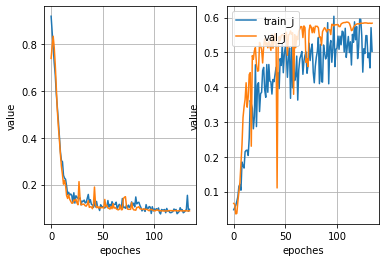

In [7]:
config['LOGGER'].info(f'fit model')
fit(model, data)



In [8]:
config['LOGGER'].info(f'store model')
store(model)

store_debug()


2022-04-14 04:45:24,562 - __main__ - INFO - store model


In [9]:
infer_aug = A.Compose([ 
                        A.Resize ( height=512,
                                   width=512,
                                   interpolation=1,
                                   always_apply=False,
                                   p=1. ),
                        A.Normalize ( mean=(0.485, 0.456, 0.406),
                                      std=(0.229, 0.224, 0.225),
                                      max_pixel_value=255.0,
                                      always_apply=False,
                                      p=1.0 )
                      ])

def inverse_infer_aug(height, width):
    return A.Compose([
                       A.Resize ( height=height,
                                  width=width,
                                  interpolation=cv2.INTER_NEAREST,
                                  always_apply=False,
                                  p=1. ) 
                    ])

In [10]:
def inner_test_loop(model, imgpathes, maskpathes):
    model.eval()
    size = len(maskpathes)

    masks = list()
    pred_masks = list()
    batch_losses = list()

    with torch.no_grad():
            #imgpathes_batch = imgpathes[batch_ids]
            #maskpathes_batch = maskpathes[batch_ids]

            imgs_batch, masks_batch = augmented_load(imgpathes, maskpathes, infer_aug)

            imgs_batch = torch_float(imgs_batch, config['DEVICE']).cpu()      
            masks_batch = torch_long(masks_batch, config['DEVICE']).cpu()

            logits_batch = model(imgs_batch.cuda()).cpu()
            loss = cross_entropy_with_logits_loss(masks_batch, logits_batch)

            pred_masks_batch = logits_batch.argmax(dim=1)
            pred_masks_batch = pred_masks_batch.cpu().data.numpy()

            masks.append(masks_batch)
            pred_masks.append(pred_masks_batch)
            batch_losses.append(loss.item())

           # del imgpathes_batch, maskpathes_batch, imgs_batch
#     # torch.cuda.empty_cache()

    masks = np.concatenate(masks)
    pred_masks = np.concatenate(pred_masks)
    
    masks = masks.clip(max=1)
    pred_masks = pred_masks.clip(max=1)
    
    #plt.imshow(pred_masks[0], cmap = 'gray')

    jaccard_score_none = jaccard_score(masks, pred_masks, average='none')

    score = jaccard_score_none[1]

    return score, np.mean(batch_losses)


In [11]:
def load_test_data(path):
    imgpathes = []
    maskpathes= []
    for imgpath in os.listdir(path):
            if imgpath.split('.')[-1] == 'jpg':
                imgpathes.append(path + '/' + imgpath)
                mask_name = imgpath.replace('.jpg','_mask.png')
                maskpathes.append(path + '/' + mask_name)              
    return imgpathes, maskpathes 

In [12]:
def create_test_model(model_file):
    model = UnetSm( out_channels=2,
                    encoder_name='efficientnet-b0' )
 
    with open(model_file, 'rb') as f:
        state = pickle.load(f)

    model.load_state_dict(state)
    model.cuda()

    return model

In [13]:
test_path = '/home/jupyter-fly_cv/Igor/Plants/Segment_dataset/test'
model_path = '/home/jupyter-fly_cv/Igor/Plants/03-06:16-03-22_model_plant_segmentation.bin'

In [14]:
model = create_test_model(model_path)
img_names,mask_names = load_test_data(test_path) 
inner_test_loop(model,img_names, mask_names)

(0.6593262606196374, 0.011559238657355309)